## CS345 Fall 2024 Assignment 2

Updated 9/13/2024

### Preliminaries

We'll start with a review of the notation used to represent a labeled dataset. In supervised learning we work with a dataset of $N$ labeled examples, each of which is a pair $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i$ is a $d$-dimensional vector (we always use boldface to denote vectors), and $y_i$ is the label associated with $\mathbf{x}_i$.  Keep in mind that the formulation of the perceptron algorithm that we used in class relies on the labels being $\pm 1$, so make sure that is the case for the data you use!

In this assignment we will use the following datasets:


* The [QSAR](https://archive.ics.uci.edu/dataset/254/qsar+biodegradation) data for predicting the biochemical activity of a molecule.
* The [Wisconsin breast cancer dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). 
* The [Gisette](https://archive.ics.uci.edu/dataset/170/gisette) handwritten digit recognition dataset. For this dataset you are provided separate training/validation/test sets.  Since the test set doesn't come with labels, use the validation set for testing the classifier.
* The [heart disease diagnosis](https://archive.ics.uci.edu/dataset/45/heart+disease) dataset.
 

## Part 0:  Data Loaders

Write data loaders for each of the four datasets listed above.  Use the same API as in assignment 1 for creating the penguins dataset, which mimics the data loaders provided by scikit-learn.

For example, a function ```load_qsar``` should return a feature matrix X and labels vector y for this dataset.  Similarly for the other datasets.  For the ```load_breast_cancer``` function, you may use the scikit-learn function that creates the dataset.  Since the gisette dataset has separate training and validation sets (that you will use as training / test sets), you will need to write two data loaders - one for the training set, and one for the test set.  Note that you will need to convert the labels from the values 0,1 to $\pm 1$, since that is what our perceptron learning algorithm expects as label values.

#### Missing values
Whenever a dataset has missing values, any training example that has missing features should be removed.  (An alternative to removing training examples is to *impute* missing features, e.g. by replacing missing values by the average of that feature.)

#### File structure

Store all the files you download in a sub-directory called `data` relative to the location of your notebook.  
Make sure to use the filenames specified in each data loader.
This will ensure that your code will run properly when we execute your notebook

#### A note on the heart disease diagnosis dataset
The heart disease diagnosis dataset has several data files associated with it.  Use [this file](http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data), where categorical variables have been replaced with numerical vaues.  The last column in the file contains the label associated with each example.  In the processed file, a label `0` corresponds to a healthy individual; other values correspond to varying levels of heart disease.  **In your experiments focus on the binary classification problem of trying to distinguish between healthy and non-healthy individuals.**


In [5]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib as plt
from sklearn.metrics import accuracy_score

In [ ]:
# complete the following data loaders.
# All the data files should be in a sub-folder called "data" relative to the
# location of your notebook.
# In each dataloader we specify the expected filenames you should use
# to ensure your notebook runs correctly

def load_qsar():
    filename='data/biodeg.csv'
    biodeg_data = pd.read_csv(filename, delimiter=';', dtype=object, skipinitialspace=True, header=None).values
    biodeg_data[biodeg_data[:, -1] == "RB", -1] = 1
    biodeg_data[biodeg_data[:, -1] == "NRB", -1] = -1
    qsar_X = biodeg_data[:,:-1].astype(np.float64) 
    qsar_y = biodeg_data[:,-1].astype(np.float64)
    return qsar_X, qsar_y

def breast_cancer_loader():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    y[y == 0] = -1
    return X, y

def load_gisette_train():
    features_filename='data/gisette_train.data'
    labels_filename='data/gisette_train.labels'
    train_data = np.loadtxt(features_filename, dtype = float)
    train_labels = np.loadtxt(labels_filename, dtype = int)
    return train_data, train_labels

def load_gisette_test():
    features_filename='data/gisette_valid.data'
    labels_filename='data/gisette_valid.labels'
    valid_data = np.loadtxt(features_filename, dtype = float)
    valid_labels = np.loadtxt(labels_filename, dtype = int)
    return valid_data, valid_labels
    
def load_heart():
    heart_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    heart_data = pd.read_csv(heart_url, header=None, na_values='?', dtype=np.float64).values 
    heart_data = heart_data[~np.isnan(heart_data).any(axis=1)]
    X = heart_data[:, :-1]
    y = heart_data[:,-1]
    return X,y

You can use the following function to check that your function returns arrays of the appropriate shapes (you will need to determine how many features / examples each dataset contains).  The only case where this is somewhat of a challenge is the heart dataset, which contains some missing values.

In [7]:
def data_is_valid(X, y, examples=0, features=0):
    return (
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all((y==1) | (y==-1))
    )

# for example:
hX, hy = load_heart()
qX, qy = load_qsar()
gX, gy = load_gisette_train()
print(hX.shape)
print("validity for heart dataset: ", data_is_valid(hX, hy, examples=297, features=13))

(297, 13)
validity for heart dataset:  False


## Part 1:  Evaluating the Perceptron on Real World Datasets

In this part of the assignment you will work with the perceptron algorithm and run it on two real-world datasets.  For comparison, you will also evaluate an [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) classifier on the same datasets.  We will cover SVMs in detail later in the course, and here you will simply use it with its default settings.

- Compare the performance of the  perceptron using the implementation we used in class with the SVM classifier on the QSAR and breast cancer diagnosis datasets. Do so by estimating the accuracy on a sample of the data that you reserve for testing (the test set).  In each case reserve  70% of the data for training, and 30% for testing.  To gain more confidence in your error estimates, repeat this experiment using 10 random splits of the data into training/test sets for each algorithm.  Use the same train-test splits for each algorithm.  Report the average accuracy and its standard deviation in a nicely formatted table.  Is there a classifier among the two that appears to perform better?  In answering this, consider the differences in performance you observe in comparison to the standard deviation.  Make sure to let the perceptron algorithm run for a sufficient number of epochs.  In implementing this task, you may use a for loop to iterate over the 10 random splits.

A note about the classifier API:  in this course we follow the scikit-learn classifier API, which requires that a classifier have the following methods (in addition to a constructor):

* `fit(X, y)`:  trains a classifier using a feature matrix `X` and a labels vector `y`.
* `predict(X)`:  given a feature matrix `X`, return a vector of labels for each feature vector represented by `X`.

For those interested in more information about the scikit-learn API, here's a [link](https://scikit-learn.org/stable/developers/develop.html).


### A note about displaying your results

We recommend displaying the results of your experiments in the form of an automatically-generated table.  pandas DataFrame objects render nicely in Jupyter notebooks, and are an easy way to achieve this with minimal work.  Here's an example that you can use as a template:

In [8]:
class perceptron :
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, iterations=100, learning_rate=0.2, 
                 plot_data=False, random_w=False, seed=42) :
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.plot_data = plot_data
        self.random_w = random_w
        self.seed = seed
  
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        
        if self.random_w :
            rng = np.random.default_rng(self.seed)
            self.w = rng.uniform(-1 , 1, len(X[0]))
            print("initialized with random weight vector")
        else :
            self.w = np.zeros(len(X[0]))
            print("initialized with a zeros weight vector")
        self.wold = self.w
        converged = False
        iteration = 0
        while (not converged and iteration <= self.iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.wold = self.w
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if self.plot_data:
                        self.plot_update(X, y, i)
            iteration += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iteration)
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
        scores = np.dot(X, self.w)
        return np.sign(scores)
    
    def plot_update(self, X, y, ipt) :
        fig = plt.figure(figsize=(4,4))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.arrow(0,0,self.w[0],self.w[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='darkred')
        plt.arrow(0,0,self.wold[0],self.wold[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='orange')
        anew = -self.w[0]/self.w[1]
        pts = np.linspace(-1,1)
        plt.plot(pts, anew*pts, color='darkred')
        if self.wold[1] != 0 :
            aold = -self.wold[0]/self.wold[1]
            plt.plot(pts, aold*pts, color='orange')
        plt.title("in orange:  old w; in red:  new w")
        cols = {1: 'g', -1: 'b'}
        for i in range(len(X)): 
            plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6,markersize=5) 
        plt.plot(X[ipt][0], X[ipt][1], 'ro', alpha=0.2,markersize=15)

In [9]:
X_qsar, y_qsar = load_qsar()
X_bc, y_bc = breast_cancer_loader()

def find_accuracy_values(X, y):
    accuracies_perceptron = []
    for  i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        perceptron_model = perceptron(iterations=1000, learning_rate=0.2)
        perceptron_model.fit(X_train, y_train)
        y_pred = perceptron_model.predict(X_test)
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        accuracies_perceptron.append(accuracy)
    mean_accuracy = np.mean(accuracies_perceptron)
    stddev_accuracy = np.std(accuracies_perceptron)
    return mean_accuracy, stddev_accuracy

def find_svm_values(X,y):
    accuracies_svm = []
    for  i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        svm = SVC(kernel = 'linear', C=1.0)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies_svm.append(accuracy)
    mean_svm_accuracy = np.mean(accuracies_svm)
    stddev_svm_accuracy = np.std(accuracies_svm)
    return mean_svm_accuracy, stddev_svm_accuracy
    

qsar_mean, qsar_stddev = find_accuracy_values(X_qsar, y_qsar)
bc_accuracy, bc_stddev = find_accuracy_values(X_bc, y_bc)
qsar_svm_accuracy, qsar_svm_stddev = find_svm_values(X_qsar,y_qsar)
bc_svm_accuracy, bc_svm_stddev = find_svm_values(X_bc,y_bc)


initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector


In [10]:
data = [
    ['Perceptron (cancer)',qsar_mean , qsar_stddev],
    ['SVM (cancer)', bc_accuracy, bc_stddev],
    ['Perceptron (biodeg)', qsar_svm_accuracy, qsar_svm_stddev],
    ['SVM (biodeg)', bc_svm_accuracy, bc_svm_stddev],
]
pd.DataFrame(data, columns = ['Classifier', 'Mean', 'StdDev'])

,Classifier,Mean,StdDev
0,Perceptron (cancer),0.798738,0.048846
1,SVM (cancer),0.881287,0.045603
2,Perceptron (biodeg),0.860568,0.008900
3,SVM (biodeg),0.959649,0.009942


The svm proved to have a higher accuracy on each of the sets, with less of a deviation as well. This would make sense because svm's reduce the effect of outliers and maximize margins.

## Part 2:  Learning Curves 

Whenever we train a classifier it is useful to know if we have collected a sufficient amount of data for accurate classification.  A good way of determining that is to construct a **learning curve**, which is a plot of classifier performance as a function of the number of training examples.  Plot a learning curve for the perceptron algorithm using the [Gisette](http://archive.ics.uci.edu/dataset/170/gisette) handwritten digit recognition dataset. For this dataset use the separately provided validation set for testing your classifiers.  A test set is provided without its labels, so is not usable for us.
The x-axis for the plot (number of training examples) should be on a logarithmic scale - something like 10,20,40,80,200,400,800 etc.  In your submission use numbers that are appropriate for the dataset at hand.  Since the x-axis is on a logarithmic scale, plot the learning curve using [plt.semilogx](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogx.html).

What can you conclude from the learning curve you have constructed for this particular dataset?

In answering this question, you can use the following [wikipedia article](https://en.wikipedia.org/wiki/Learning_curve#In_machine_learning).
Make sure that you use a fixed test set to evaluate performance while varying the size of the training set.  Use the Gisette validation set for that purpose.
Also, do not use the scikit-learn function for computing the validation curve, or any other scikit-learn functions for this task.

In [11]:
X_train,y_train = load_gisette_train()
X_valid,y_valid = load_gisette_test()

initialized with a zeros weight vector
converged in 3 iterations 
initialized with a zeros weight vector
converged in 5 iterations 
initialized with a zeros weight vector
converged in 5 iterations 
initialized with a zeros weight vector
converged in 6 iterations 
initialized with a zeros weight vector
converged in 7 iterations 
initialized with a zeros weight vector
converged in 7 iterations 
initialized with a zeros weight vector
converged in 8 iterations 
initialized with a zeros weight vector
converged in 13 iterations 
initialized with a zeros weight vector
converged in 13 iterations 
initialized with a zeros weight vector
converged in 12 iterations 
initialized with a zeros weight vector
converged in 12 iterations 


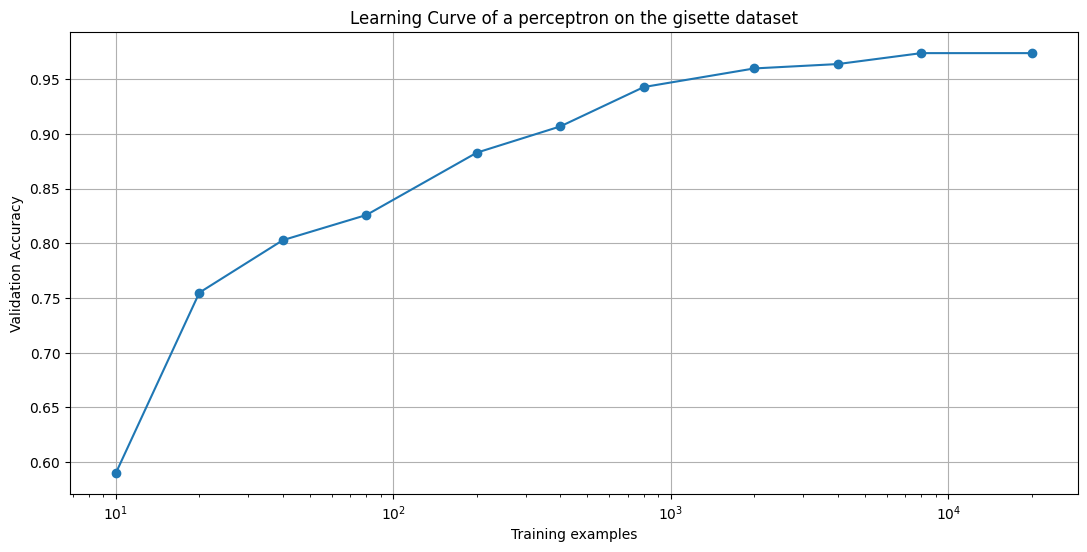

In [12]:
import matplotlib.pyplot as plt
import numpy as np
accuracies = []
training_sizes = [10, 20, 40, 80, 200, 400, 800, 2000, 4000, 8000, 20000,]

for size in training_sizes:
    X_subset = X_train[:size]
    y_subset = y_train[:size]

    perceptron_model = perceptron(iterations=1000, learning_rate=0.2)
    perceptron_model.fit(X_subset, y_subset)
    y_pred = perceptron_model.predict(X_valid)
    accuracy = np.mean(y_pred == y_valid)
    accuracies.append(accuracy)

fig = plt.figure(figsize=(13,6))
plt.semilogx(training_sizes,accuracies, marker = 'o', linestyle='-')
plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curve of a perceptron on the gisette dataset")
plt.grid(True)

From this graph you can see that at a lower number of training sets, there is a much lower accuracy but it climbs quickly and peaks at around 10000. 

## Part 3:  Data standardization 

In this section we will explore the effect of normalizing the data, focusing on normalization of each feature individually.  In class we saw how to convert each column (i.e. feature) of a data matrix so that it fall in the range $[-1,1]$.  In this assignment we will explore a different approach callled **standardization**.

Here's what you need to do:

* Write a method to standardize a data matrix, so that each column has zero mean and standard deviation equal to 1.  This is done by subtracting the mean of each column, and dividing by its standard deviation.  See details [here](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)).  Scikit-learn has a method called [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which does this.  Do not use it!  To demonstrate that your method works correctly, show that after standardization, your feature matrix has a zero mean and standard deviation equal to 1 for each column.  Make sure not to use for loops!

* Compare the accuracy of the standard perceptron on the heart dataset  with standardization and without it (make sure to evaluate the accuracy on a held out test set).  Like we did earlier, report the accuracy as the average over ten train-test splits.  Which leads to better performance?  Can you explain why?


In [13]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

def train_perceptron(X, y):
    accuracies = []
    
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        model = perceptron(iterations = 1000, learning_rate = 0.3, random_w=False, seed=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)
        mean_accuracy = np.mean(accuracies)
    return mean_accuracy

heart_X, heart_y = load_heart()
standardized_X = standardize(heart_X)

print("Mean:", np.mean(standardized_X, axis=0))
print("Std dev:", np.std(standardized_X, axis=0))

mean_accuracy = train_perceptron(heart_X,heart_y)
mean_standardized_accuracy = train_perceptron(standardized_X,heart_y)

print(mean_accuracy)
print(mean_standardized_accuracy)

Mean: [-1.05041303e-16 -2.78864100e-16 -4.63527458e-17  4.76143629e-16
 -2.36156026e-16  5.60718699e-17  1.97372982e-16  5.14365953e-16
 -2.50454352e-17 -2.79985537e-16  1.27096239e-17 -2.22792230e-16
 -1.16255677e-16]
Std dev: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weight vector
initialized with a zeros weig

There was no real indication that the normalization process led to a improvement in the accuracy of the perceptron. I would assume that this is incorrect as normalization is supposed to reduce the variability of the dataset.

### Part 4:  Use of AI and other web resources

In the cell below indicate in detail how you used AI and other web resources for this assignment.  If you used AI tools, indicate how useful they were.

For this assignment i used a variety of websites, as well as the course website to find the information needed to complete the assignment.

### Your Report

Answer the questions in the cells reserved for that purpose.


### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the results and plots in your notebook.

### Grading 


```
Grading sheet for assignment 2
Part 0:  20 points
Part 1:  40 points
Part 2:  20 points
Part 3:  20 points
```

